# __Animal Detection System__
#### Project by Nikolas White

### __Project Overview__

This system aims to detect an animal based on a given image. This model is trained off of hundreds of moose, beaver and cat images and therefore is only suitable for identifying if an image looks closest to a moose, beaver or cat. 

__Important__: The following code/data is a basic format for this sort of image detection project. Significant improvements must be made in order to design a reliable system. Improvements can be through: higher quality images (zoom into animals, eliminate drawings/ai generated images), more images (using zoom/crop techniques to reuse the same image) and longer training time (increase epoch).

In [2]:
import warnings
warnings.filterwarnings('ignore')

### __Model Building__

TensorFlow version: 2.16.2
Found 761 images belonging to 3 classes.
Found 189 images belonging to 3 classes.
Training samples: 761
Validation samples: 189
Classes found: {'beaver': 0, 'cat': 1, 'moose': 2}
Samples per class in training set: [257 238 266]
Samples per class in validation set: [64 59 66]
Epoch 1/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3310 - loss: 1.2217 - val_accuracy: 0.4444 - val_loss: 1.0928
Epoch 2/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4240 - loss: 1.0705 - val_accuracy: 0.4127 - val_loss: 1.0831
Epoch 3/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4583 - loss: 1.0503 - val_accuracy: 0.4550 - val_loss: 1.0779
Epoch 4/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5019 - loss: 0.9991 - val_accuracy: 0.4392 - val_loss: 1.0504
Epoch 5/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4805 - loss: 1.0098 - val_accuracy: 0.6032 - val_loss: 0.9777
Epoch 6/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 979ms/step - accuracy: 0.

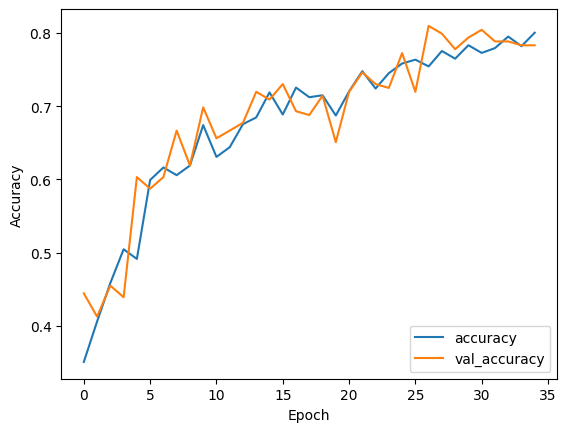

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - accuracy: 0.7603 - loss: 0.5711
Validation Loss: 0.5999674797058105
Validation Accuracy: 0.7407407164573669


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Directories for datasets
data_dir = 'dataset'

# Image parameters
img_height, img_width = 128, 128
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Check if data generators are correctly initialized
print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')

# Verify the classes and sample distribution
print('Classes found:', train_generator.class_indices)
print('Samples per class in training set:', np.bincount(train_generator.classes))
print('Samples per class in validation set:', np.bincount(validation_generator.classes))

# Ensure there are enough samples
if train_generator.samples < 10 or validation_generator.samples < 10:
    raise ValueError("Not enough images for training/validation. Please add more images to your dataset.")

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Training the model
try:
    history = model.fit(
        train_generator,
        epochs=35,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint]
    )
except Exception as e:
    print(f"Error during training: {e}")

# Plotting the training history
if 'history' in locals():
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.savefig('training_history.png')
    plt.show()

# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')


### __Model Evaluation__

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


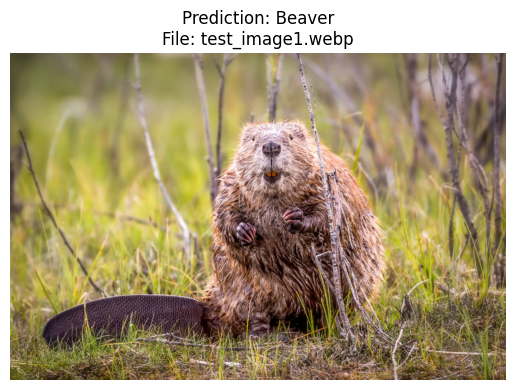

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


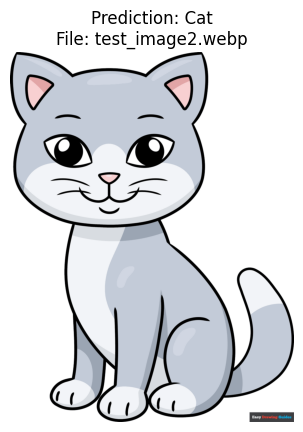

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


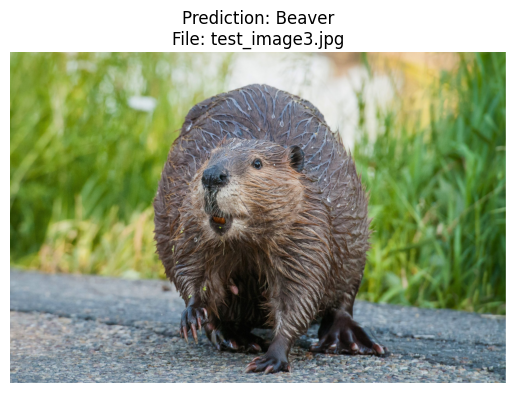

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


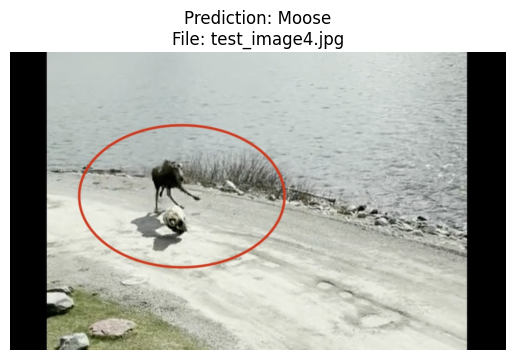

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('best_model.keras')

# Define the class names
class_names = ['Beaver', 'Moose', 'Cat']

# List of image file names
image_files = ['test_image1.webp', 'test_image2.webp', 'test_image3.jpg', 'test_image4.jpg']

# Function to load, preprocess, and predict the class of an image
def predict_image(file_name):
    # Load and preprocess the image
    img = load_img(file_name, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the prediction and the image
    plt.imshow(load_img(file_name))
    plt.title(f'Prediction: {predicted_class}\nFile: {file_name}')
    plt.axis('off')
    plt.show()

# Predict for each image in the list
for image_file in image_files:
    predict_image(image_file)
